<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/baseline_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline code
This code introduces a two-step training for the problem. It may be better doing only one-step, i.e. from noisy patch to descriptor directly, but this provides an initial valid submission to use as a first step.

The outputs you see here are with only some minutes of training, so results should be better if the models are trained for more time.



## Initial check

We first check the amount of memory we have in the notebook. Usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm()

('Gen RAM Free: 12.9 GB', ' | Proc size: 151.6 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Downloading functions and data

The first step is to clone a GitHub repository with some functions implemented, and also downloading and extracting the HPatches data. We can run command line commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we use to change directory (`cd`). It takes around 5 minutes to download and unzip the dataset. 


In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 169 (delta 19), reused 22 (delta 10), pack-reused 128
Receiving objects: 100% (169/169), 149.84 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (69/69), done.


In [0]:
# Change directory
%cd /content/keras_triplet_descriptor    

/content/keras_triplet_descriptor


In [0]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-02-17 09:35:28--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-17 09:35:28--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-17 09:35:28--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [0]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing necessary modules

We now import the modules we will use in this baseline code. The read_data and utils imports are function provided in the repository we just cloned.

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt


We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

The HPatches dataset has several splits, where it separates the sequences available in train sequences and test sequences. We load the split 'a'. 

In [0]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


## Models and loss

We now define three functions that define main modules of our baseline. First, we have a function that returns a denoising model. The input for the function is the size of the patch, which will be 1x64x64, and it outputs a keras model.

Then we have a similar function for the descriptor model, the model we use as baseline takes as input a patch of size 1x32x32, and returns a descriptor. Then we will use the triplet loss.

You can modify the models in this functions and run the training code again for your new models. For example, the given UNet is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weigths. Or maybe adding dropout. Or modifying the loss somehow....

In [0]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
                 #kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.00001), 
                
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001), 
                 

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
               #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001), 
               
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
                 #kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.00001), 
                 
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet


def get_autoencoder_model(shape):
  inputs = Input(shape)
  # fold input
  encode  = Dense(32, (3, 3), activation='relu', padding='same')(inputs)
  pool1  = MaxPooling2D((2, 2), padding='same')(conv1)
  conv2  = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
  encoded = MaxPooling2D((2, 2), padding='same')(conv2)


  conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  deconv1 = UpSampling2D((2, 2))(conv3)
  conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(deconv1)
  deconv2 = UpSampling2D((2, 2))(conv4)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(deconv2)
  
  autoencoder = Model(inputs=inputs,outputs=decoded)
  return autoencoder


def get_descriptor_model(shape):
  '''Architecture copies HardNet architecture'''
  init_weights = keras.initializers.he_normal()
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(Reshape((128,)))
  return descriptor_model
  
  
def triplet_loss(x):
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising patches


We use the DenoiseHPatches class implemented in the read_data.py file, which takes as input the list of sequences to load. It outputs batches where the input data is the noisy image and the label is the clean image, so then we can use a mean absolute error metric (or MSE also works) as loss function. 

Here we take a subset of training and validation sequences by using random.sample (3 sequences for training and 1 for validation data). The purpose of doing so was just to speed-up training for generating faster the output of this notebook. Remove the random.sample function to give the generator all the training data.

In [0]:
#denoise_generator = DenoiseHPatches(random.sample(seqs_train, 2), batch_size=50)
#denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

denoise_generator = DenoiseHPatches(seqs_train, batch_size=500)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=500)




100%|██████████| 40/40 [00:45<00:00,  1.15s/it]


In [0]:
shape = (32, 32, 1)
denoise_model = get_denoise_model(shape)
#denoise_model = get_autoencoder_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [0]:
opt = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
opt = keras.optimizers.nadam()

early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto')
#checkpoint = keras.callbacks.ModelCheckpoint(MODEL_FILEPATH, monitor='val_loss', verbose=3, save_best_only=True, mode='auto')
callbacks_list = [
    early_stopping, 
    #checkpoint
]

denoise_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])
denoise_history = denoise_model.fit_generator(generator=denoise_generator,  epochs=50, callbacks=callbacks_list,
                                              verbose=1, validation_data=denoise_generator_val)
denoise_model.save_weights('denoise.h5') 

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
3117/3117 [==============================] - 636s 204ms/step - loss: 7.9640 - mean_absolute_error: 7.9640 - val_loss: 6.3013 - val_mean_absolute_error: 6.3013
Epoch 2/50
3117/3117 [==============================] - 629s 202ms/step - loss: 6.0543 - mean_absolute_error: 6.0543 - val_loss: 5.6539 - val_mean_absolute_error: 5.6539
Epoch 3/50
3117/3117 [==============================] - 630s 202ms/step - loss: 5.6351 - mean_absolute_error: 5.6351 - val_loss: 5.4687 - val_mean_absolute_error: 5.4687
Epoch 4/50
3117/3117 [==============================] - 628s 201ms/step - loss: 5.4603 - mean_absolute_error: 5.4603 - val_loss: 5.3807 - val_mean_absolute_error: 5.3807
Epoch 5/50
3117/3117 [==============================] - 630s 202ms/step - loss: 5.3674 - mean_absolute_error: 5.3674 - val_loss: 5.3433 - val_mean_absolute_error: 5.3433
Epoch 6/50
3117/3117 [==============================] - 629s 202ms/step - loss: 5.3091 - mean_absolute

plot training loss history

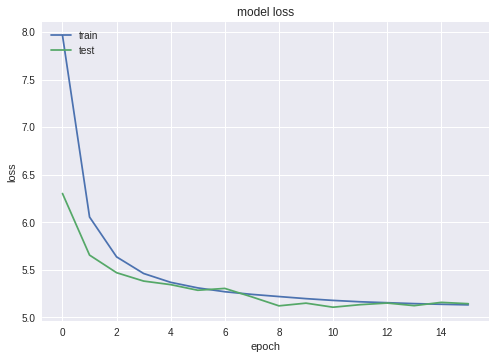

In [0]:
plt.plot(denoise_history.history['loss'])
plt.plot(denoise_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

You may want to save the weights in your local disk. To do so, use:



In [0]:
from google.colab import files
files.download('denoise.h5')

### Visualization of denoising results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


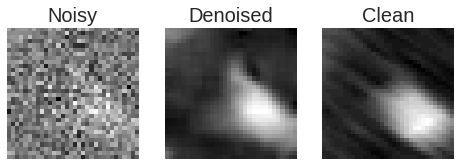

In [0]:
plot_denoise(denoise_model)

## Training a Descriptor Network
Now we train the network that generates the descriptors for the patch. We are going to use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

In [0]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs = [xa, xp, xn], outputs = loss)
sgd = keras.optimizers.SGD(lr = 0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Here we use the class HPatches, which loads the corresponding files by using the method read_image_file. It reads the clean patches, which are the ones used for training in this baseline code. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class DataGeneratorDesc. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

In [0]:
### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames = train_fnames, test_fnames = test_fnames)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 1), num_triplets = 100000)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 0), num_triplets = 10000)


Using noisy patches
100%|██████████| 116/116 [00:38<00:00,  3.01it/s]


100%|██████████| 100000/100000 [00:01<00:00, 57845.26it/s]


Using noisy patches
100%|██████████| 116/116 [00:22<00:00,  2.29it/s]


100%|██████████| 10000/10000 [00:00<00:00, 60789.13it/s]


We plot a random triplet in the form of anchor, positive and negative sample

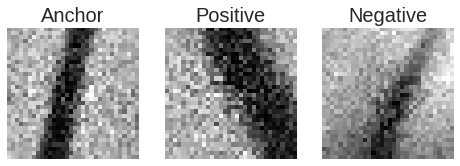

In [0]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [0]:
history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=50, verbose=1, validation_data=val_generator)
descriptor_model.save_weights('hardnet.h5') 

Epoch 1/50
 394/2000 [====>.........................] - ETA: 2:23 - loss: 0.3119

## Generating descriptors files for test data 

HPatches benchmark takes as input the descriptors for the test data in a CSV form. This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to None), the descriptor is computed directly in the noisy patch.

In [0]:
generate_desc_csv(descriptor_model, denoise_model, seqs_test)

100%|██████████| 40/40 [07:43<00:00,  9.87s/it]


## Evaluating descriptors in HPatches Benchmark
We first download the official repository for HPatches Benchmark.

In [0]:
!git clone https://github.com/hpatches/hpatches-benchmark


Cloning into 'hpatches-benchmark'...
remote: Enumerating objects: 1379, done.
remote: Total 1379 (delta 0), reused 0 (delta 0), pack-reused 1379
Receiving objects: 100% (1379/1379), 239.58 MiB | 20.52 MiB/s, done.
Resolving deltas: 100% (758/758), done.
Checking out files: 100% (135/135), done.


Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script.

### Verification



In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:29<00:00, 11152.96it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:30<00:00, 11071.81it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:31<00:00, 10930.76it/s]
>> Verification task finished in 280 secs  
Verification task results:
CUSTOM - Balanced variant (auc) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.919498  0.887013
Hard     0.899671  0.8601
Tough    0.871768  0.825558
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.806251  0.721069
Hard     0.738682  0.627186
Tough    0.657986  0.536444




### Matching

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=matching



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:11<00:00,  4.44s/it]
>> Matching task finished in 131 secs  
Matching task results:
CUSTOM - mAP 
    Easy       Hard      Tough       mean
--------  ---------  ---------  ---------
0.176051  0.0613619  0.0211228  0.0861787






### Retrieval

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=retrieval



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x55dabd9de000 @  0x7efeb780f1e7 0x7efead410cf1 0x7efead4733a2 0x7efead4750de 0x7efead50c0e8 0x55da981c6fe5 0x55da981bcd0a 0x55da981c45fe 0x55da981c4232 0x55da981bcd0a 0x55da981c4c38 0x55da981bcd0a 0x55da981bc629 0x55da981ed61f 0x55da981e8322 0x55da981e767d 0x55da981961ab 0x7efeb740cb97 0x55da98195a2a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [04:00<00:00, 39.39it/s]
>> Retrieval task finished in 262 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000      10000      15000      20000
-------  --------  --------  --------  --------  ---------  ---------  ---------
Easy     0.718503  0.570151  0.51332   0.390093  0.342892   0.317955   0.302852
Hard     0.648096  0.451448  0.376005

## Compressing and saving the CSV files 

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

File ID: 1-e2KuQ39Lgc26EzcwVu3drBeBk4aKmFd


{u'id': u'1-e2KuQ39Lgc26EzcwVu3drBeBk4aKmFd'}